## Classification on 8 celebrities

In this notebook we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". There are 350 images of each celebrity, we use 250 for traning and 50 for validation and test.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Reading in the data, it is already prepared in a train, validation and testset. The class labels are form 0 to 7. The pixelsize of every image is 48x48 and we have 3 channels (RGB) per image. All 3 sets are balanced.

In [2]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1",
    "8_faces_train_and_valid.hdf5")

In [3]:
h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


(array([250., 250., 250., 250., 250., 250., 250., 250.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

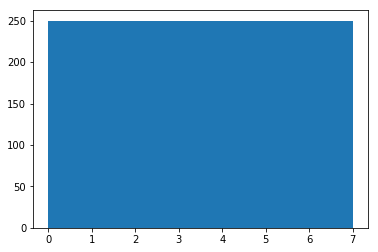

In [4]:
plt.hist(Y_train,bins=8)

(array([50., 50., 50., 50., 50., 50., 50., 50.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

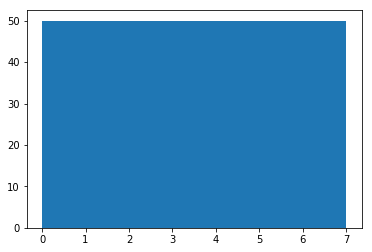

In [5]:
plt.hist(Y_valid,bins=8)

How hard is this task? Lets plot some random image of the trainset to get an impression of the images and of  the task. 

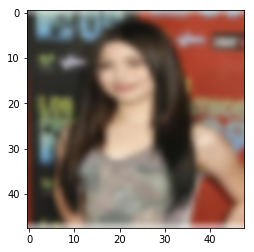

In [6]:
rmd=np.random.randint(0,len(X_train))
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"),interpolation="bicubic")

#### Normalization of the training and validationset.

In [7]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

#### Flattern the images into a vector because we unly use fully connected layers in this model

In [8]:
X_train_flatten=np.zeros([len(X_train),48*48*3])
for i in range(0,len(X_train)):
    X_train_flatten[i]=np.reshape(X_train[i],newshape=((48*48*3),))
    
X_valid_flatten=np.zeros([len(X_valid),48*48*3])
for i in range(0,len(X_valid)):
    X_valid_flatten[i]=np.reshape(X_valid[i],newshape=((48*48*3),))
print(X_train_flatten.shape)
print(X_valid_flatten.shape)

(2000, 6912)
(400, 6912)


Define the convertToOneHot function and convert the labels into the onehot encoding.

In [9]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [10]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [11]:
print(Y_train[13])
print(Y_valid[13])

[0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0]


### Define the network

In [12]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [13]:
batch_size = 128
nb_classes = 8
nb_epoch = 50

In [14]:
model = Sequential()
name = 'only_fc'

model.add(Dense(400,input_dim=(48*48*3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               2765200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               200500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
__________

### Running a forward pass of the untrained network

In [16]:
model.evaluate(X_train_flatten,Y_train)

2000/2000 [==============================] - 1s 575us/step


[2.2854409065246584, 0.106]

In [17]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

In [18]:
#save model after every 10 epochs in "Checkpoints/8_facesl/model_1_fc/"-folder
os.makedirs("Checkpoints/8_faces/model_1_fc/",exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  "Checkpoints/8_faces/model_1_fc/fc_model_"+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

### Training the network

In [19]:
history=model.fit(X_train_flatten, Y_train, 
                  batch_size=batch_size, 
                  epochs=nb_epoch,
                  verbose=2, 
                  validation_data=(X_valid_flatten, Y_valid),
                  callbacks=[tensorboard,checkpointer],)

Train on 2000 samples, validate on 400 samples
Epoch 1/50
 - 3s - loss: 2.4650 - acc: 0.1810 - val_loss: 1.9960 - val_acc: 0.3325
Epoch 2/50
 - 2s - loss: 2.1516 - acc: 0.2615 - val_loss: 1.7760 - val_acc: 0.3750
Epoch 3/50
 - 2s - loss: 2.0083 - acc: 0.2955 - val_loss: 1.6613 - val_acc: 0.4175
Epoch 4/50
 - 2s - loss: 1.9013 - acc: 0.3190 - val_loss: 1.6302 - val_acc: 0.4175
Epoch 5/50
 - 2s - loss: 1.7963 - acc: 0.3480 - val_loss: 1.5514 - val_acc: 0.4525
Epoch 6/50
 - 2s - loss: 1.7249 - acc: 0.3770 - val_loss: 1.5150 - val_acc: 0.4850
Epoch 7/50
 - 2s - loss: 1.6043 - acc: 0.4205 - val_loss: 1.4381 - val_acc: 0.4975
Epoch 8/50
 - 2s - loss: 1.6004 - acc: 0.4255 - val_loss: 1.4287 - val_acc: 0.4925
Epoch 9/50
 - 2s - loss: 1.5105 - acc: 0.4605 - val_loss: 1.3726 - val_acc: 0.5125
Epoch 10/50
 - 2s - loss: 1.4937 - acc: 0.4665 - val_loss: 1.3513 - val_acc: 0.5200

Epoch 00010: saving model to Checkpoints/8_faces/model_1_fc/fc_model_weights_epoch_010-1.35.hdf5
Epoch 11/50
 - 2s - loss

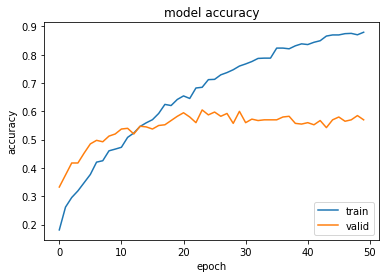

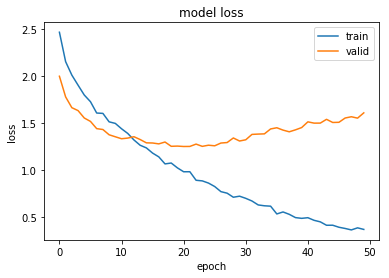

In [21]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Evaluation of the trained network

In [22]:
#load a saved model
from keras.models import load_model
model = load_model("Checkpoints/8_faces/model_1_fc/fc_model_weights_epoch_020-1.25.hdf5")

In [24]:
preds=model.predict(X_valid_flatten)

In [26]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(Y_valid,axis=1),np.argmax(preds,axis=1)))
print("Acc = " ,np.sum(np.argmax(Y_valid,axis=1)==np.argmax(preds,axis=1))/len(preds))

[[36  1  3  2  1  1  5  1]
 [ 1 19  2  8  6 10  1  3]
 [ 6  3 33  3  0  0  1  4]
 [ 2  4  2 36  1  3  2  0]
 [ 1  2  0  1 43  1  1  1]
 [ 4  4  4  2  3 30  2  1]
 [10  2  2  4  4  3 21  4]
 [ 6  7  7  4  2  6  3 15]]
Acc =  0.5825


### You will get the test set next week, optimize your network on the validation set